The following additional libraries are needed to run this
notebook. Note that running on Colab is experimental, please report a Github
issue if you have any problem.

In [ ]:
!pip install d2l==0.17.1
!pip install -U mxnet-cu101==1.7.0


# Filtragem Neural Colaborativa para Classificação Personalizada

Esta seção vai além do feedback explícito, apresentando a estrutura de filtragem neural colaborativa (NCF) para recomendação com feedback implícito. O feedback implícito é generalizado nos sistemas de recomendação. Ações como cliques, compras e relógios são comentários implícitos comuns que são fáceis de coletar e indicam as preferências dos usuários. O modelo que apresentaremos, intitulado NeuMF :cite:`He.Liao.Zhang.ea.2017`, abreviação de fatoração da matriz neural, visa abordar a tarefa de classificação personalizada com feedback implícito. Este modelo aproveita a flexibilidade e não linearidade das redes neurais para substituir produtos pontuais da fatoração de matrizes, visando aumentar a expressividade do modelo. Especificamente, este modelo é estruturado com duas sub-redes, incluindo fatoração de matriz generalizada (GMF) e MLP e modela as interações de duas vias em vez de produtos internos simples. As saídas dessas duas redes são concatenadas para o cálculo final das pontuações de predição. Ao contrário da tarefa de previsão de classificação no AutoRec, este modelo gera uma lista de recomendação classificada para cada usuário com base no feedback implícito. Usaremos a perda de classificação personalizada introduzida na última seção para treinar este modelo.

## O modelo NeuMF

Como mencionado anteriormente, o NeuMF funde duas sub-redes. O GMF é uma versão de rede neural genérica de fatoração de matriz em que a entrada é o produto elemento a elemento dos fatores latentes do usuário e do item. Consiste em duas camadas neurais:

$$
\mathbf{x} = \mathbf{p}_u \odot \mathbf{q}_i \\
\hat{y}_{ui} = \alpha(\mathbf{h}^\top \mathbf{x}),
$$

onde $\odot$ denota o produto de vetores de Hadamard. $\mathbf{P} \in \mathbb{R}^{m \times k}$ e $\mathbf{Q} \in \mathbb{R}^{n \times k}$ corresponda à matriz latente do usuário e do item respectivamente. $\mathbf{p}_u \in \mathbb{R}^{ k}$ é a linha $u^\mathrm{th}$ de $\mathbf{q}_i \in \mathbb{R}^{ k}$ é $i^\mathrm{th}$ linha de $Q$. $\alpha$ e $h$ denotam a função de ativação e o peso da camada de saída. $\hat{y}_{ui}$ é a pontuação de predição que o usuário $u$ pode dar ao item $i$.

Outro componente deste modelo é o MLP. Para enriquecer a flexibilidade do modelo, a sub-rede MLP não compartilha os embeddings de usuário e item com GMF. Ele usa a concatenação de embeddings de usuário e item como entrada. Com conexões complicadas e transformações não lineares, é capaz de estimar as intrincadas interações entre usuários e itens. Mais precisamente, a sub-rede MLP é definida como:

$$
\begin{aligned}
z^{(1)} &= \phi_1(\mathbf{U}_u, \mathbf{V}_i) = \left[ \mathbf{U}_u, \mathbf{V}_i \right] \\
\phi^{(2)}(z^{(1)})  &= \alpha^1(\mathbf{W}^{(2)} z^{(1)} + b^{(2)}) \\
&... \\
\phi^{(L)}(z^{(L-1)}) &= \alpha^L(\mathbf{W}^{(L)} z^{(L-1)} + b^{(L)})) \\
\hat{y}_{ui} &= \alpha(\mathbf{h}^\top\phi^L(z^{(L-1)}))
\end{aligned}
$$

onde $\mathbf{W}^*, \mathbf{b}^*$ e $\alpha^*$ denotam a matriz de peso, vetor de polarização e função de ativação. $\phi^*$ denota a função da camada correspondente. $\mathbf{z}^*$ denota a saída da camada correspondente.

Para fundir os resultados de GMF e MLP, em vez da adição simples, NeuMF concatena as penúltimas camadas de duas sub-redes para criar um vetor de recursos que pode ser passado para as camadas posteriores. Posteriormente, as saídas são projetadas com a matriz $\mathbf{h}$ e uma função de ativação sigmóide. A camada de previsão é formulada como:
$$
\hat{y}_{ui} = \sigma(\mathbf{h}^\top[\mathbf{x}, \phi^L(z^{(L-1)})]).
$$

A figura a seguir ilustra a arquitetura do modelo do NeuMF.

![Ilustração do modelo NeuMF](../img/rec-neumf.svg)


In [1]:
import random
import mxnet as mx
from mxnet import autograd, gluon, np, npx
from mxnet.gluon import nn
from d2l import mxnet as d2l

npx.set_np()

## Implementação do Modelo

O código a seguir implementa o modelo NeuMF. Ele consiste em um modelo de fatoração de matriz generalizado e um perceptron em várias camadas com diferentes vetores e vetores de incorporação de itens. A estrutura do MLP é controlada com o parâmetro `nums_hiddens`. ReLU é usado como a função de ativação padrão.


In [2]:
class NeuMF(nn.Block):
    def __init__(self, num_factors, num_users, num_items, nums_hiddens,
                 **kwargs):
        super(NeuMF, self).__init__(**kwargs)
        self.P = nn.Embedding(num_users, num_factors)
        self.Q = nn.Embedding(num_items, num_factors)
        self.U = nn.Embedding(num_users, num_factors)
        self.V = nn.Embedding(num_items, num_factors)
        self.mlp = nn.Sequential()
        for num_hiddens in nums_hiddens:
            self.mlp.add(nn.Dense(num_hiddens, activation='relu',
                                  use_bias=True))
        self.prediction_layer = nn.Dense(1, activation='sigmoid', use_bias=False)

    def forward(self, user_id, item_id):
        p_mf = self.P(user_id)
        q_mf = self.Q(item_id)
        gmf = p_mf * q_mf
        p_mlp = self.U(user_id)
        q_mlp = self.V(item_id)
        mlp = self.mlp(np.concatenate([p_mlp, q_mlp], axis=1))
        con_res = np.concatenate([gmf, mlp], axis=1)
        return self.prediction_layer(con_res)

## Conjunto de dados personalizado com amostragem negativa

Para a perda de classificação aos pares, uma etapa importante é a amostragem negativa. Para cada usuário, os itens com os quais um usuário não interagiu são itens candidatos (entradas não observadas). A função a seguir pega a identidade dos usuários e os itens candidatos como entrada e faz a amostragem de itens negativos aleatoriamente para cada usuário do conjunto de candidatos desse usuário. Durante o estágio de treinamento, o modelo garante que os itens que um usuário gosta sejam classificados acima dos itens que ele não gosta ou com os quais não interagiu.


In [3]:
class PRDataset(gluon.data.Dataset):
    def __init__(self, users, items, candidates, num_items):
        self.users = users
        self.items = items
        self.cand = candidates
        self.all = set([i for i in range(num_items)])

    def __len__(self):
        return len(self.users)

    def __getitem__(self, idx):
        neg_items = list(self.all - set(self.cand[int(self.users[idx])]))
        indices = random.randint(0, len(neg_items) - 1)
        return self.users[idx], self.items[idx], neg_items[indices]

## Avaliador

Nesta seção, adotamos a estratégia de divisão por tempo para construir os conjuntos de treinamento e teste. Duas medidas de avaliação, incluindo taxa de acerto em determinado corte $\ell$ ($\text{Hit}@\ell$) e área sob a curva ROC (AUC) são usadas para avaliar a eficácia do modelo. A taxa de acerto em determinada posição $\ell$ para cada usuário indica que se o item recomendado está incluído na lista de $\ell$ superior. A definição formal é a seguinte:

$$
\text{Hit}@\ell = \frac{1}{m} \sum_{u \in \mathcal{U}} \textbf{1}(rank_{u, g_u} <= \ell),
$$

onde $\textbf{1}$ denota uma função de indicador que é igual a um se o item de verdade está classificado na lista $\ell$ superior, caso contrário, é igual a zero. $rank_{u, g_u}$ denota a classificação do item de verdade $g_u$ do usuário $u$ na lista de recomendação (a classificação ideal é 1). $m$ é o número de usuários. $\mathcal{U}$ é o conjunto do usuário.

A definição de AUC é a seguinte:

$$
\text{AUC} = \frac{1}{m} \sum_{u \in \mathcal{U}} \frac{1}{|\mathcal{I} \backslash S_u|} \sum_{j \in I \backslash S_u} \textbf{1}(rank_{u, g_u} < rank_{u, j}),
$$

onde $\mathcal{I}$ é o item definido. $S_u$ são os itens candidatos do usuário $u$. Observe que muitos outros protocolos de avaliação, como precisão, recuperação e ganho cumulativo com desconto normalizado (NDCG), também podem ser usados.

A função a seguir calcula as contagens de ocorrências e AUC para cada usuário.


In [4]:
#@save
def hit_and_auc(rankedlist, test_matrix, k):
    hits_k = [(idx, val) for idx, val in enumerate(rankedlist[:k])
              if val in set(test_matrix)]
    hits_all = [(idx, val) for idx, val in enumerate(rankedlist)
                if val in set(test_matrix)]
    max = len(rankedlist) - 1
    auc = 1.0 * (max - hits_all[0][0]) / max if len(hits_all) > 0 else 0
    return len(hits_k), auc

Em seguida, a taxa geral de acertos e a AUC são calculadas como segue.


In [5]:
#@save
def evaluate_ranking(net, test_input, seq, candidates, num_users, num_items,
                     devices):
    ranked_list, ranked_items, hit_rate, auc = {}, {}, [], []
    all_items = set([i for i in range(num_users)])
    for u in range(num_users):
        neg_items = list(all_items - set(candidates[int(u)]))
        user_ids, item_ids, x, scores = [], [], [], []
        [item_ids.append(i) for i in neg_items]
        [user_ids.append(u) for _ in neg_items]
        x.extend([np.array(user_ids)])
        if seq is not None:
            x.append(seq[user_ids, :])
        x.extend([np.array(item_ids)])
        test_data_iter = gluon.data.DataLoader(
            gluon.data.ArrayDataset(*x), shuffle=False, last_batch="keep",
            batch_size=1024)
        for index, values in enumerate(test_data_iter):
            x = [gluon.utils.split_and_load(v, devices, even_split=False)
                 for v in values]
            scores.extend([list(net(*t).asnumpy()) for t in zip(*x)])
        scores = [item for sublist in scores for item in sublist]
        item_scores = list(zip(item_ids, scores))
        ranked_list[u] = sorted(item_scores, key=lambda t: t[1], reverse=True)
        ranked_items[u] = [r[0] for r in ranked_list[u]]
        temp = hit_and_auc(ranked_items[u], test_input[u], 50)
        hit_rate.append(temp[0])
        auc.append(temp[1])
    return np.mean(np.array(hit_rate)), np.mean(np.array(auc))

## Treinamento e avaliação do modelo

A função de treinamento é definida abaixo. Treinamos o modelo de maneira pareada.


In [6]:
#@save
def train_ranking(net, train_iter, test_iter, loss, trainer, test_seq_iter,
                  num_users, num_items, num_epochs, devices, evaluator,
                  candidates, eval_step=1):
    timer, hit_rate, auc = d2l.Timer(), 0, 0
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0, 1],
                            legend=['test hit rate', 'test AUC'])
    for epoch in range(num_epochs):
        metric, l = d2l.Accumulator(3), 0.
        for i, values in enumerate(train_iter):
            input_data = []
            for v in values:
                input_data.append(gluon.utils.split_and_load(v, devices))
            with autograd.record():
                p_pos = [net(*t) for t in zip(*input_data[0:-1])]
                p_neg = [net(*t) for t in zip(*input_data[0:-2],
                                              input_data[-1])]
                ls = [loss(p, n) for p, n in zip(p_pos, p_neg)]
            [l.backward(retain_graph=False) for l in ls]
            l += sum([l.asnumpy() for l in ls]).mean()/len(devices)
            trainer.step(values[0].shape[0])
            metric.add(l, values[0].shape[0], values[0].size)
            timer.stop()
        with autograd.predict_mode():
            if (epoch + 1) % eval_step == 0:
                hit_rate, auc = evaluator(net, test_iter, test_seq_iter,
                                          candidates, num_users, num_items,
                                          devices)
                animator.add(epoch + 1, (hit_rate, auc))
    print(f'train loss {metric[0] / metric[1]:.3f}, '
          f'test hit rate {float(hit_rate):.3f}, test AUC {float(auc):.3f}')
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec '
          f'on {str(devices)}')

Agora, podemos carregar o conjunto de dados MovieLens 100k e treinar o modelo. Como há apenas classificações no conjunto de dados MovieLens, com algumas perdas de precisão, binarizamos essas classificações em zeros e uns. Se um usuário classificou um item, consideramos o feedback implícito como um, caso contrário, como zero. A ação de classificar um item pode ser tratada como uma forma de fornecer feedback implícito. Aqui, dividimos o conjunto de dados no modo `seq-aware`, onde os últimos itens interagidos dos usuários são deixados de fora para teste.


In [7]:
batch_size = 1024
df, num_users, num_items = d2l.read_data_ml100k()
train_data, test_data = d2l.split_data_ml100k(df, num_users, num_items,
                                              'seq-aware')
users_train, items_train, ratings_train, candidates = d2l.load_data_ml100k(
    train_data, num_users, num_items, feedback="implicit")
users_test, items_test, ratings_test, test_iter = d2l.load_data_ml100k(
    test_data, num_users, num_items, feedback="implicit")
train_iter = gluon.data.DataLoader(
    PRDataset(users_train, items_train, candidates, num_items ), batch_size,
    True, last_batch="rollover", num_workers=d2l.get_dataloader_workers())

Em seguida, criamos e inicializamos o modelo. usamos um MLP de três camadas com tamanho oculto constante 10.


In [8]:
devices = d2l.try_all_gpus()
net = NeuMF(10, num_users, num_items, nums_hiddens=[10, 10, 10])
net.initialize(ctx=devices, force_reinit=True, init=mx.init.Normal(0.01))

O código a seguir treina o modelo.


train loss 16.982, test hit rate 0.075, test AUC 0.531
12.9 examples/sec on [gpu(0), gpu(1)]


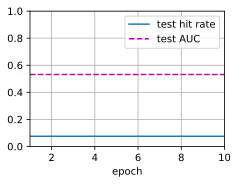

In [9]:
lr, num_epochs, wd, optimizer = 0.01, 10, 1e-5, 'adam'
loss = d2l.BPRLoss()
trainer = gluon.Trainer(net.collect_params(), optimizer,
                        {"learning_rate": lr, 'wd': wd})
train_ranking(net, train_iter, test_iter, loss, trainer, None, num_users,
              num_items, num_epochs, devices, evaluate_ranking, candidates)

## Sumário

* Adicionar não linearidade ao modelo de fatoração de matriz é benéfico para melhorar a capacidade e eficácia do modelo.
* NeuMF é uma combinação de fatoração de matriz e perceptron multicamadas. O perceptron multicamadas leva a concatenação de embeddings de usuário e item como entrada.

## Exercícios

* Varie o tamanho dos fatores latentes. Como o tamanho dos fatores latentes afetam o desempenho do modelo?
* Varie as arquiteturas (por exemplo, número de camadas, número de neurônios de cada camada) do MLP para verificar seu impacto no desempenho.
* Experimente diferentes otimizadores, taxa de aprendizado e taxa de redução de peso.
* Tente usar a perda de dobradiça definida na última seção para otimizar este modelo.


[Discussão](https://discuss.d2l.ai/t/403)


<!--stackedit_data:
eyJoaXN0b3J5IjpbMjAwMjIyODgwNSwxOTM1NjczNjQ2XX0=
-->
